# Finite-size corrections to charged defect supercells with FHI-aims
This notebook is designed for applying finite-size corrections to charged defect supercells using outputs from the [FHI-aims](https://aimsclub.fhi-berlin.mpg.de/) electronic structure software package and the FNV correction scheme (doi: 10.1103/PhysRevLett.102.016402) through integration with the CoFFEE python code.

First download and install CoFFEE from [here](https://www.sciencedirect.com/science/article/pii/S0010465518300158).

The steps below are designed to allow for easier and consistent processing of large sets of defect calculations. 
All user defined settings are in the first cell. All subsequent cells do not require user inputs. They just need to be run in order and there is an explanation of the analysis being performed before each cell. Each charged defect still needs to be processed one at a time by specifying the location of directories with the relevant data in the 'User inputs' cell. The user must then extract the correction energy from the potential alignment plot at the end of this notebook.

### Assumptions made during the processing
1. The user is using python3 and has successfully installed the CoFFEE package and its dependencies
2. The electronic and ionic components of the host crystal have already been computed
3. All defects are intrinsic defects (there are no atom types present in the defect supercell that are not also present in the perfect supercell)
4. The volume of the supercells has not been relaxed so lattice vectors are the same for the perfect and defect supercells (this is appropriate for simulating defects in the dilute limit)
5. The supercells have orthogonal axes for the lattice vectors (some numerical noise in the off-diagonals is okay)
6. A maximum of one point defect is present in each supercell
7. All filenames for FHI-aims calculations still have their original default names: 'geometry.in' and 'plane_average_realspace_ESP.out'
8. The data from all final one-shot calculations of the perfect and defect supercells are stored in one directory (one-shot meaning no relaxation steps were performed on the final structure so the only geometry files are 'geometry.in' and this corresponds to the final relaxed structures). Sub-directories for the different defects within this directory are fine and are to be expected to keep data organised!
9. The same sigma value is used for the Gaussian charge model for all defects in the same set for consistency (the maximum sigma is assumed to be the minimum distance of all defects in the set to the supercell boundary), but note that in reality the charge associated with some defects may be more or less disperse

## 1. User inputs

In [4]:
# Put here to allow notebook to be run externally for full defect dataset
%matplotlib inline 

# Dir to store output files for defect currently being processed
defect_outputs_dir = 'V-Cu_q=-1_sg=1'
# Outputs from FHI-aims calculations: dir with defect you want to perform correction for
path_to_defect = '/Users/suzy/Desktop/DefectAnalysis/EnargiteDefects/fromLandau/Results/data/final_one_shots/VacancySupercells/V-Cu/charged/-1/DefectSpacegroup1'
# Outputs from FHI-aims calculations: dir with neutral version of defect you want to correct
path_to_neutral = '/Users/suzy/Desktop/DefectAnalysis/EnargiteDefects/fromLandau/Results/data/final_one_shots/VacancySupercells/V-Cu/neutral/DefectSpacegroup1'
# Enter charge state of defect you want to perform the correction for
defect_charge = -1

# Dielectric properties of host crystal: electronic+ionic dielectric constants
dielectric_xx = 7.49 
dielectric_yy = 6.92
dielectric_zz = 7.19

# Location of CoFFEE code (this is the directory containing coffee.py and other Utilities of the CoFFEE package)
path_to_coffee_dir = '/Users/suzy/Desktop/DefectAnalysis/CoFFEE_1.1'
# Dir with all data for final one-shots of all defect supercells (inc. perfect supercell)
path_to_all_defects = '/Users/suzy/Desktop/DefectAnalysis/EnargiteDefects/fromLandau/Results/data/final_one_shots' 
# Dir with data for perfect host supercell
path_to_host = '/Users/suzy/Desktop/DefectAnalysis/EnargiteDefects/fromLandau/Results/data/final_one_shots/PerfectReference' 

# Choose names for files for outputs for correction steps
charge_model_file = 'charge_model.dat' #File containing coffee.py outputs for charge models of increasing size
pa_plot_file = 'pa_plot.png' #Name for plot for potential alignment plot for this defect

# Plane wave cutoff for Poisson solver will be computed based on sigma value of Gaussian charge model
# If this is found to not converge after running the script, option below to manually set the cutoff (e.g. 40.0)
# Leave as 'None' to let the script use the value computed based on the sigma value of the Gaussian
manual_cutoff = None

### END OF USER INPUTS ###


In [5]:
# All python libraries used in notebook
import re # Python equivalent of grep
import glob
import subprocess # alternative to os.system
from pylab import *
from numpy.linalg import *
from numpy import dot,cross,pi
from scipy.interpolate import spline
import os,sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
import numpy as np
import math
import string
from shutil import copyfile
import logging, logging.config

# Make directory for outputs from processing of this defect
#subprocess.check_call(['mkdir', defect_outputs_dir])
defect_outputs_dir = "processed_defects/"+defect_outputs_dir
os.makedirs(defect_outputs_dir, exist_ok=True)

In [10]:
# Setting up log files for workflow for current defect

# logger.info("INFO") and logger.debug("ERROR")
def configure_logging(logfile_path):
    '''
    Initialize logging defaults
    :param logfile_path: logfile used to the logfile
    :type logfile_path: string

    This function does:
    - Assign INFO level to logger file handler and console handler
    '''

    default_formatter = logging.Formatter("[%(asctime)s] [%(levelname)s] [%(name)s] [%(funcName)s():%(lineno)s] %(message)s")

    root_logger = logging.getLogger()

    info_file_handler = logging.FileHandler(logfile_path + ".info", mode='w')
    info_file_handler.setLevel(logging.INFO)

    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)

    console_handler.setFormatter(default_formatter)

    list(map(root_logger.removeHandler, root_logger.handlers[:]))
    list(map(root_logger.removeFilter, root_logger.filters[:]))
    root_logger.setLevel(logging.INFO)
    root_logger.addHandler(info_file_handler)
    root_logger.addHandler(console_handler)

    return root_logger

# Initialise log file
logger = configure_logging(defect_outputs_dir+"/log")

In [12]:
# Functions used in notebook

def read_lattice_vectors(geom_file):
    '''
    Input crystal geometry file in format for FHI-aims (geometry.in)
    Function searches for lattice vectors using string 'lattice_vector'
    Returns x, y and z components of a1, a2 and a3 lattice vectors
    E.g. x_vecs[1], y_vecs[1], z_vecs[1] would be x, y, z components of a2
    '''
    x_vecs = []
    y_vecs = []
    z_vecs = []
    try:
        with open(geom_file, 'r') as f:
            for line in f:
                if re.search('lattice_vector', line):
                    words = line.split()
                    x_vecs.append(float(words[1]))
                    y_vecs.append(float(words[2]))
                    z_vecs.append(float(words[3]))
                    if line == None:
                        logger.info('Warning! - No lattice vectors found in '+str(geom_file))
    except IOError:
        logger.info("Could not open "+str(geom_file))
    return x_vecs, y_vecs, z_vecs


def get_supercell_dimensions(geom_file):
    '''
    Take maximum of each direction to be supercell dimension for orthogonal unit cells
    (allowing for some numerical noise in off-diagonals)
    Return list 'supercell_dims' where x = supercell_dims[0], y = supercell_dims[0], z = supercell_dims[2]
    '''
    x_vecs, y_vecs, z_vecs = read_lattice_vectors(geom_file)
    supercell_dims = []
    supercell_dims.append(max(x_vecs))
    supercell_dims.append(max(y_vecs))
    supercell_dims.append(max(z_vecs))
    return supercell_dims


def read_atom_coords(geom_file):
    '''
    Input crystal geometry file in format for FHI-aims (geometry.in)
    Function searches for atom using string 'atom' to allow for either 'atom' or 'atom_frac' in the file format
    Returns list of lists for all atom coordinates where atom_coords[row][col]
    Columns are: x, y, z, species
    '''
    atom_coords = []
    try:
        with open(geom_file, 'r') as f:
            for line in f:
                if re.search('atom', line):
                    words = line.split()
                    atom_coords.append((float(words[1]), float(words[2]), float(words[3]), str(words[4])))
                    if line == None:
                        logger.info('Warning! - No atom coordinates found in '+str(geom_file))
    except IOError:
        logger.info("Could not open "+str(geom_file))
    return atom_coords


def find_defect_type(host_coords, defect_coords):
    '''
    Compares number of atoms in defect and host supercells to determine type of defect
    host_atom_num == defect_atom_num+1 --> vacancy
    host_atom_num == defect_atom_num-1 --> interstitial
    host_atom_num == defect_atom_num --> antisite
    '''
    host_atom_num = len(host_coords)
    defect_atom_num = len(defect_coords)
    if (host_atom_num == defect_atom_num+1):
        defect_type = 'vacancy'
    elif (host_atom_num == defect_atom_num-1):
        defect_type = 'interstitial'
    elif (host_atom_num == defect_atom_num):
        defect_type = 'antisite'
    else:
        logger.info('Error finding defect type')
    return defect_type


def count_species(host_coords, defect_coords):
    '''
    Read through species in atom_coords[row][3] for host and defect supercells
    First function output is a list of all different species present in the host supercell
    Next two outputs are the number of each of these species in the host and defect supercell, in the same order
    Assumption is made that only intrinsic defects are present, hence same species are present in host and defect supercells
    '''
    # Obtain list of all species contained in host supercell
    species = []
    current_species = host_coords[0][3]
    species.append(host_coords[0][3])
    for i in range(0, len(host_coords)):
        if (host_coords[i][3] != current_species):
            species.append(host_coords[i][3])
            current_species = host_coords[i][3]         
    # Count number of each species in host supercell
    host_species_nums = []
    for j in range(0, len(species)):
        species_count = 0
        for i in range(0, len(host_coords)):
            if (host_coords[i][3] == species[j]):
                species_count += 1
        host_species_nums.append(int(species_count))
    # Count number of each species in defect supercell
    defect_species_nums = []
    for j in range(0, len(species)):
        species_count = 0
        for i in range(0, len(defect_coords)):
            if (defect_coords[i][3] == species[j]):
                species_count += 1
        defect_species_nums.append(int(species_count))       
    return species, host_species_nums, defect_species_nums
    
       
def find_vacancy(host_coords, defect_coords):
    '''
    Find species where count is one less in defect supercell than in host supercell
    '''
    species, host_species_nums, defect_species_nums = count_species(host_coords, defect_coords)
    species_vac = 'no vacancy'
    for i in range (0, len(species)):
        if (host_species_nums[i] == defect_species_nums[i]+1):
            species_vac = species[i]
    if (species_vac == 'no vacancy'):
        logger.info('Error finding vacancy')
    return species_vac


def find_interstitial(host_coords, defect_coords):
    '''
    Find species where count is one more in defect supercell than in host supercell
    '''
    species, host_species_nums, defect_species_nums = count_species(host_coords, defect_coords)
    species_int = 'no interstitial'
    for i in range (0, len(species)):
        if (host_species_nums[i] == defect_species_nums[i]-1):
            species_int = species[i]
    if (species_int == 'no interstitial'):
        logger.info('Error finding interstitial')
    return species_int


def find_antisite(host_coords, defect_coords):
    '''
    Find species where count is one less in defect supercell than in host (species_out)
    Find species where count is one more in defect supercell than in host (species_in) 
    '''
    species, host_species_nums, defect_species_nums = count_species(host_coords, defect_coords)
    species_in = 'no species in'
    species_out = 'no species out'
    for i in range (0, len(species)):
        if (host_species_nums[i] == defect_species_nums[i]-1):
            species_in = species[i]
        if (host_species_nums[i] == defect_species_nums[i]+1):
            species_out = species[i]
    if (species_in == 'no species in' or species_out == 'no species out'):
        logger.info('Error finding antisite')
    return species_in, species_out


def vacancy_coords(host_coords, defect_coords):
    '''
    Define vacancy coordinates in perfect host supercell
    '''
    species_vac = find_vacancy(host_coords, defect_coords)  
    # Read in coordinates of vacancy species in perfect host supercell
    host_vac_coords = []
    for i in range (0, len(host_coords)):
        if (host_coords[i][3] == species_vac):
            host_vac_coords.append(host_coords[i][:3])
    # Read in coordinates of vacancy species in defect supercell
    defect_vac_coords = []
    for i in range (0, len(defect_coords)):
        if (defect_coords[i][3] == species_vac):
            defect_vac_coords.append(defect_coords[i][:3]) 
    # Find closest vacancy species in defect supercell for each one in host supercell
    all_closest_species = []
    for x_host, y_host, z_host in host_vac_coords:
        # USE np.argmin??
        closest_species = None
        min_distance = None
        for x_defect, y_defect, z_defect in defect_vac_coords:
            distance_to_defect = sqrt( (abs(x_host-x_defect)*abs(x_host-x_defect)) + (abs(y_host-y_defect)*abs(y_host-y_defect)) + (abs(z_host-z_defect)*abs(z_host-z_defect)))
            if min_distance is None or distance_to_defect < min_distance:
                min_distance = distance_to_defect
                closest_species = [x_defect, y_defect, z_defect]
        all_closest_species.append(closest_species + [min_distance])
    # Find which species in host where the 'closest distance' to a species in the defect supercell is largest
    # This is identified as the vacancy in te host supercell
    x_vac, y_vac, z_vac = host_coords[np.argmax([i[3] for i in all_closest_species])][:3]
    # Above in one-liner version of code commented out below
    #max_dist = 0
    #for i in range(0, len(all_closest_species)):
    #    if (all_closest_species[i][3] > max_dist):
    #        x_vac, y_vac, z_vac = host_coords[i][:3]
    #        max_dist = all_closest_species[i][3] 
    return species_vac, x_vac, y_vac, z_vac


def interstitial_coords(host_coords, defect_coords):
    '''
    Define interstitial coordinates in defect supercell
    '''
    species_int = find_interstitial(host_coords, defect_coords)  
    # Read in coordinates of interstitial species in perfect host supercell
    host_int_coords = []
    for i in range (0, len(host_coords)):
        if (host_coords[i][3] == species_int):
            host_int_coords.append(host_coords[i][:3])
    # Read in coordinates of interstitial species in defect supercell
    defect_int_coords = []
    for i in range (0, len(defect_coords)):
        if (defect_coords[i][3] == species_int):
            defect_int_coords.append(defect_coords[i][:3]) 
    # Find closest interstitial species in host supercell for each one in defect supercell
    all_closest_species = []
    for x_defect, y_defect, z_defect in defect_int_coords:
        # USE np.argmin??
        closest_species = None
        min_distance = None
        for x_host, y_host, z_host in host_int_coords:
            distance_to_defect = sqrt( (abs(x_host-x_defect)*abs(x_host-x_defect)) + (abs(y_host-y_defect)*abs(y_host-y_defect)) + (abs(z_host-z_defect)*abs(z_host-z_defect)))
            if min_distance is None or distance_to_defect < min_distance:
                min_distance = distance_to_defect
                closest_species = [x_host, y_host, z_host]
        all_closest_species.append(closest_species + [min_distance])
    # Find which species in defect where the 'closest distance' to a species in the host supercell is largest
    # This is identified as the interstitial in the defect supercell
    x_int, y_int, z_int = defect_coords[np.argmax([i[3] for i in all_closest_species])][:3]
    return species_int, x_int, y_int, z_int


def antisite_coords(host_coords, defect_coords):
    '''
    Define antisite coordinates in defect supercell
    '''
    species_in, species_out = find_antisite(host_coords, defect_coords)
    # Find species_in in defect supercell mostly using function for finding interstitial
    # Read in coordinates of antisite_in species in perfect host supercell
    host_in_coords = []
    for i in range (0, len(host_coords)):
        if (host_coords[i][3] == species_in):
            host_in_coords.append(host_coords[i][:3])
    # Read in coordinates of antisite_in species in defect supercell
    defect_in_coords = []
    for i in range (0, len(defect_coords)):
        if (defect_coords[i][3] == species_in):
            defect_in_coords.append(defect_coords[i][:3]) 
    # Find closest interstitial species in host supercell for each one in defect supercell
    all_closest_species = []
    for x_defect, y_defect, z_defect in defect_in_coords:
        # USE np.argmin??
        closest_species = None
        min_distance = None
        for x_host, y_host, z_host in host_in_coords:
            distance_to_defect = sqrt( (abs(x_host-x_defect)*abs(x_host-x_defect)) + (abs(y_host-y_defect)*abs(y_host-y_defect)) + (abs(z_host-z_defect)*abs(z_host-z_defect)))
            if min_distance is None or distance_to_defect < min_distance:
                min_distance = distance_to_defect
                closest_species = [x_host, y_host, z_host]
        all_closest_species.append(closest_species + [min_distance])
    # Find which species in defect where the 'closest distance' to a species in the perfect supercell is largest
    # This is identified as the species added into in the defect supercell
    x_in, y_in, z_in = defect_coords[np.argmax([i[3] for i in all_closest_species])][:3]
    return species_in, species_out, x_in, y_in, z_in


def defect_to_boundary(x_defect, y_defect, z_defect, supercell_x, supercell_y, supercell_z):
    # Finding minimum x, y, z distance of defect from supercell boundaries
    x_min = x_defect if (x_defect <= supercell_x/2.0) else supercell_x - x_defect
    y_min = y_defect if (y_defect <= supercell_y/2.0) else supercell_y - y_defect
    z_min = z_defect if (z_defect <= supercell_z/2.0) else supercell_z - z_defect
    return x_min, y_min, z_min


def write_CoFFEE_in_file(defect_outputs_dir, super_x, super_y, super_z, geom_file, sigma, defect_charge, defect_x, defect_y, defect_z, dielectric_xx, dielectric_yy, dielectric_zz):
    ### Writing 'in' file for coffee.py
    coffee_in = open(str(defect_outputs_dir)+"/cm_"+str(super_x)+"x"+str(super_y)+"x"+str(super_z)+"_in", "w")
    ## CELL PARAMS
    coffee_in.write("&CELL_PARAMETERS\n")
    coffee_in.write("\n")
    coffee_in.write("Lattice_Vectors(normalized):\n")
    # Read in lattice vectors from geometry.in, normalize and write to 'in' file for CoFFEE
    x_vecs, y_vecs, z_vecs = read_lattice_vectors(defect_geom)
    a1_tot = x_vecs[0]+y_vecs[0]+z_vecs[0]
    a2_tot = x_vecs[1]+y_vecs[1]+z_vecs[1]
    a3_tot = x_vecs[2]+y_vecs[2]+z_vecs[2]
    coffee_in.write(str(x_vecs[0]/a1_tot)+"   "+str(y_vecs[0]/a1_tot)+"   "+str(z_vecs[0]/a1_tot)+"\n")
    coffee_in.write(str(x_vecs[1]/a2_tot)+"   "+str(y_vecs[1]/a2_tot)+"   "+str(z_vecs[1]/a2_tot)+"\n")
    coffee_in.write(str(x_vecs[2]/a3_tot)+"   "+str(y_vecs[2]/a3_tot)+"   "+str(z_vecs[2]/a3_tot)+"\n")
    coffee_in.write("\n")
    coffee_in.write("Cell_dimensions angstrom\n")
    coffee_in.write(str(a1_tot*super_x)+"  "+str(a2_tot*super_y)+"   "+str(a3_tot*super_z)+"\n")
    coffee_in.write("\n")
    coffee_in.write("Ecut="+str(cutoff)+" Hartree\n")
    coffee_in.write("/\n")
    coffee_in.write("\n")
    ## DIELECTRIC PARAMS
    coffee_in.write("&DIELECTRIC_PARAMETERS Bulk\n")
    coffee_in.write("Epsilon1_a1 = "+str(dielectric_xx)+"\n")
    coffee_in.write("Epsilon1_a2 = "+str(dielectric_yy)+"\n")
    coffee_in.write("Epsilon1_a3 = "+str(dielectric_zz)+"\n")
    coffee_in.write("/\n")
    coffee_in.write("\n")
    ## GAUSSIAN PARAMS (used for charge model)
    coffee_in.write("&GAUSSIAN_PARAMETERS:\n")
    coffee_in.write("Total_charge = "+str(defect_charge)+"\n")
    coffee_in.write("Sigma = "+str(sigma)+"\n")
    # Centre of Gaussian is set as defect location
    coffee_in.write("Centre_a1 = "+str(defect_x/a1_tot)+"\n") # CHECK THIS IS CORRECT! (in crystal units?!)
    coffee_in.write("Centre_a2 = "+str(defect_y/a2_tot)+"\n")
    coffee_in.write("Centre_a3 = "+str(defect_z/a3_tot)+"\n")
    coffee_in.write("/\n")
    coffee_in.close()
    

## 2. Read in information for your perfect host crystal supercell

In [13]:
# Read in geometry information for perfect host crystal
host_geom = os.path.join(path_to_host, 'geometry.in')
host_coords = read_atom_coords(host_geom)
# Read in supercell dimensions from perfect crystal (should be same for defect supercells if volume fixed)
supercell_dims = get_supercell_dimensions(host_geom)

## 3. Determine sigma for the Gaussian models for your defect set
The purpose is to determine the value of sigma for the Gaussian charge models that is small enough to ensure that the charge is contained within the supercell for all supercells, including the ones where the defect is closest to the boundary of the supercell. For consistency, it is desirable to use the same value of sigma for all defects in your set of calculations.

**This step needs to only be run once for your set of defects, so if it turns out to be slow for a large set of defects just run it once and for subsequent runs replace the cell below with a cell that just contains:**

`sigma = computed_value_from_first_run`

In [14]:
all_distances_to_boundaries = []
for geom_file in glob.glob(path_to_all_defects+'/**/geometry.in', recursive=True):
    if not os.path.samefile(geom_file, host_geom):
        defect_coords = read_atom_coords(geom_file)
        defect_type = find_defect_type(host_coords, defect_coords)
        if (defect_type == 'vacancy'):
            species_vac, defect_x, defect_y, defect_z = vacancy_coords(host_coords, defect_coords)
        elif (defect_type == 'interstitial'):
            species_int, defect_x, defect_y, defect_z = interstitial_coords(host_coords, defect_coords)
        elif (defect_type == 'antisite'):
            species_in, species_out, defect_x, defect_y, defect_z = antisite_coords(host_coords, defect_coords)
        else:
            logger.info("Error identifying defect type in "+str(geom_file))
        all_distances_to_boundaries.append(min(defect_to_boundary(defect_x, defect_y, defect_z, supercell_dims[0], supercell_dims[1], supercell_dims[2])))

closest_defect_to_boundary = abs(min(all_distances_to_boundaries))
# Define sigma for Gaussian as 2*(smallest dist of any defect to boundary) and convert units from Angstrom to Bohr
sigma = 2*closest_defect_to_boundary*1.88973
logger.info("Sigma used for Gaussian charge model = "+str(sigma))

NameError: name 'logger' is not defined

In [11]:
# sigma = computed_value_from_first_run
#sigma = 0.16890641066519999
#sigma = 1.4 # Test value

## 4. Determine cutoff for Poisson solver based on sigma of Gaussian charge model

The script below sets the cutoff for the plane waves used in CoFFEE's Poisson solver. Smaller sigma values require more plane waves to achieve convergence and the more plane waves the slower the solver will be. 

If it turns out that you are unable to achieve convergence with the cutoff value set based on sigma, there is also the option to override the value and set this manually. This is the 'manual_cutoff' variable in step 1.

In [12]:
# Script to compute plane wave cutoff based on sigma (20.0 Hartree was fine for sigma=1.4)
cutoff_ratio = 20.0/1.4 # Found to converge well in tests
cutoff = cutoff_ratio/sigma

# Override computed value if user has set a manual cutoff
cutoff = manual_cutoff if manual_cutoff else cutoff

## 5. Locate the defect coordinates
This script locates the coordinates of the defect by comparing the defect supercell to the perfect host supercell.
The defect position is referenced to the species that would be in the perfect host in the case of a vacancy, e.g. the S atom removed from the host to make a S vacancy. The position is referenced to the atom added to the defect supercell in the case of an intersitial or antisite.

These coordinates will be used to define the centre of the Gaussian used in the charge model in the 'in' file used with the Poisson solver in coffee.py. The z-position of the defect will also be used when generating plots of planar average of potentials for the potential alignment (pa).

In [13]:
# Find defect then find min distance of defect to boundary

defect_geom = path_to_defect+'/geometry.in'
defect_coords = read_atom_coords(defect_geom)

defect_type = find_defect_type(host_coords, defect_coords)
if (defect_type == 'vacancy'):
    species_vac, defect_x, defect_y, defect_z = vacancy_coords(host_coords, defect_coords)
    logger.info('Defect is a '+str(species_vac)+' vacancy with charge '+str(defect_charge))
    logger.info('Defect coordinates in host supercell: '+str(defect_x)+', '+str(defect_y)+', '+str(defect_z))
elif (defect_type == 'interstitial'):
    species_int, defect_x, defect_y, defect_z = interstitial_coords(host_coords, defect_coords)
    logger.info('Defect is a '+str(species_int)+' interstitial with charge '+str(defect_charge))
    logger.info('Defect coordinates in defect supercell: '+str(defect_x)+', '+str(defect_y)+', '+str(defect_z))
elif (defect_type == 'antisite'):
    species_in, species_out, defect_x, defect_y, defect_z = antisite_coords(host_coords, defect_coords)
    logger.info('Defect is a '+str(species_in)+'-on-'+str(species_out)+' antisite with charge '+str(defect_charge))
    logger.info('Defect coordinates in defect supercell: '+str(defect_x)+', '+str(defect_y)+', '+str(defect_z))
else:
    logger.info("Error identifying defect type")


Defect is a Cu vacancy
Defect coordinates in host supercell: 1.81418799, 4.29641122, 11.59370564


### Smallest distances of the defect from the supercell boundary:

Nearest defect distances to supercell boundaries: 1.81418799, 4.29641122, 0.7409631799999996


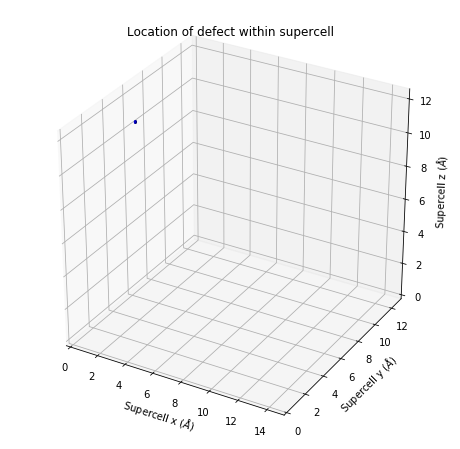

HErE


In [46]:
min_x, min_y, min_z = defect_to_boundary(defect_x, defect_y, defect_z, supercell_dims[0], supercell_dims[1], supercell_dims[2])
logger.info("Nearest defect distances to supercell boundaries: "+str(min_x)+", "+str(min_y)+", "+str(min_z))

from mpl_toolkits import mplot3d
from IPython.core.pylabtools import figsize
figsize(8, 8)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
# Radius of sphere is sigma of Gaussian charge model converted back into Angstroms
x = sigma/1.88973 * np.outer(np.cos(u), np.sin(v)) + defect_x
y = sigma/1.88973 * np.outer(np.sin(u), np.sin(v)) + defect_y
z = sigma/1.88973 * np.outer(np.ones(np.size(u)), np.cos(v)) + defect_z

ax.plot_surface(x, y, z, color='b')
ax.set_xlim3d(0,supercell_dims[0])
ax.set_ylim3d(0,supercell_dims[1])
ax.set_zlim3d(0,supercell_dims[2])
ax.set_xlabel('Supercell x ($\AA$)')
ax.set_ylabel('Supercell y ($\AA$)')
ax.set_zlabel('Supercell z ($\AA$)')
plt.title('Location of defect within supercell')
plt.tight_layout()
plt.savefig(str(defect_outputs_dir)+"/defect_location.png")

plt.show(block=False)

## 6. Determine E_q^{lat} from the Gaussian charge model

E_q^{lat} term: E_q^{lat} = E_q^{iso,m} - E_q^{per,m}

See the [CoFFEE](https://www.sciencedirect.com/science/article/pii/S0010465518300158) paper for details.

### 6a. Generate 'in' files for charge model calculation and run Possion solver with coffee.py
This is used to obtain E_q^{per,m} for the charge model that is the same size as the supercell used in the DFT defect calculations and then also to calculate E_q^{per,2m} and E_q^{per,3m} for 2x2x2 and 3x3x3 supercells of the DFT supercell.

The values computed for all three supercells will be used in step 6b to obtain E_q^{iso,m} for the charge model from a fit to the three data points and extrapolating to the limit of an infinite supercell.

In [15]:
## Note to self: Ensure coffee3 env is activated in terminal this notebook is launched from

# Charge model for 3x3x3 supercell of the supercell used in DFT calculations, use to obtain E_q^{per,3m}
write_CoFFEE_in_file(defect_outputs_dir, 3, 3, 3, defect_geom, sigma, defect_charge, defect_x, defect_y, defect_z, dielectric_xx, dielectric_yy, dielectric_zz)
# Run CoFFEE Poisson solver to obtain E_q^per,m
try:
    subprocess.check_output(str(path_to_coffee_dir)+"/coffee.py "+str(defect_outputs_dir)+"/cm_3x3x3_in > "+str(defect_outputs_dir)+"/cm_3x3x3.out", shell=True, stderr=subprocess.STDOUT)
except Exception as err:
    logger.info(err.output)
    
# Charge model for 2x2x2 supercell of the supercell used in DFT calculations, use to obtain E_q^{per,2m}
write_CoFFEE_in_file(defect_outputs_dir, 2, 2, 2, defect_geom, sigma, defect_charge, defect_x, defect_y, defect_z, dielectric_xx, dielectric_yy, dielectric_zz)
# Run CoFFEE Poisson solver to obtain E_q^per,2m
try:
    subprocess.check_output(str(path_to_coffee_dir)+"/coffee.py "+str(defect_outputs_dir)+"/cm_2x2x2_in > "+str(defect_outputs_dir)+"/cm_2x2x2.out", shell=True, stderr=subprocess.STDOUT)
except Exception as err:
    logger.info(err.output)


In [25]:
# The 1x1x1 supercell (i.e. same as original defect supercell size) is run last 
# This is to ensure V_r.npy left in the directory is for this system for subsequent analysis
# Charge model for same size supercell as used in DFT calculations, use to obtain E_q^{per,m}
write_CoFFEE_in_file(defect_outputs_dir, 1, 1, 1, defect_geom, sigma, defect_charge, defect_x, defect_y, defect_z, dielectric_xx, dielectric_yy, dielectric_zz)
# Run CoFFEE Poisson solver to obtain E_q^per,3m
try:
    subprocess.check_output(str(path_to_coffee_dir)+"/coffee.py "+str(defect_outputs_dir)+"/cm_1x1x1_in > "+str(defect_outputs_dir)+"/cm_1x1x1.out", shell=True, stderr=subprocess.STDOUT)
except Exception as err:
    logger.info(err.output)
    
copyfile("V_r.npy", str(defect_outputs_dir)+"/V_r.npy")


*** Note: The two cells above may take a while to run for all three supercells ***

In [26]:
# Do python re equivalent of (grep ! ${charge_model_file}) to get E_q^per,m from output
E_q_per_m = []
for dim in range (1,4,1):
    try:
        with open(str(defect_outputs_dir)+"/cm_"+str(dim)+"x"+str(dim)+"x"+str(dim)+".out", 'r') as f:
            for line in f:
                if re.search('!', line):
                    words = line.split()
                    E_q_per_m.append(float(words[4]))
                    if line == None:
                        logger.info('Warning! - Error finding E_q^{per,m} from '+str(defect_outputs_dir)+"/cm_"+str(dim)+"x"+str(dim)+"x"+str(dim)+".out")
                        logger.info('coffee.py may still be calculating E_q^{per,m}, check inside file: '+str(defect_outputs_dir)+"/cm_"+str(dim)+"x"+str(dim)+"x"+str(dim)+".out")
    except IOError:
        logger.info("Could not open "+str(defect_outputs_dir)+"/cm_"+str(dim)+"x"+str(dim)+"x"+str(dim)+".out")   
# E_q_per_m, E_q_per_2m, E_q_per_3m
logger.info("E_q_per_m = "+str(E_q_per_m[0]), "E_q_per_2m = "+str(E_q_per_m[1]), "E_q_per_3m = "+str(E_q_per_m[2]))
# Input these into coffee script below to obtain E_iso

### 6b. Obtain E_q^{iso} from fit to E_q^{per,m} for defect supercell, 2x2x2  and 3x3x3 of this supercell

E_m_iso: 6.375268181818182
Fitting parameters (f_1,f_2,f_3): 6.375268181818182 -3.164624180110195 18.204455840663286


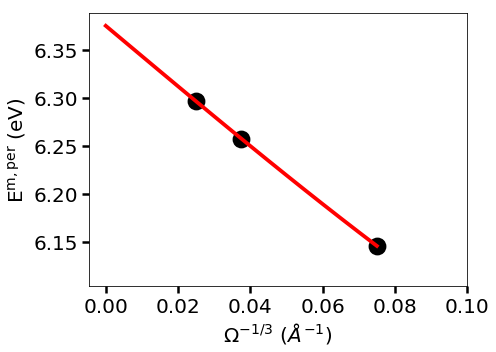

In [27]:
# Below is a plotting script adapted from plot_fit.py from the CoFFEE_1.1 Examples directory

# Uses fit to E_q_per_m, E_q_per_2m, E_q_per_3m for extrapolation to get obtain E_q^iso,m
# E_m_iso from this fit is used in the next cell to compute E_q^{lat}

# Defined at top of notebook
#import sys, string
#import numpy as np
#import matplotlib.pyplot as plt
figsize(7, 5)

def compute_fit(C_u,L2,L3,L4):
    '''
    Computes the fitting polynomial.
    C_u takes the 3 model energies
    L2, L3 and L4 are 1/\Omega^{1/3} for the corresponding cells.
    '''
    A = np.array([[ L2, L2**3, 1.], [  L3, L3**3, 1.] , [  L4, L4**3, 1. ] ])
    A_inv =  np.linalg.inv(A)
    X_u = np.dot(A_inv,C_u)
    return X_u

# alat is used as scaling parameter for lattice vectors of supercell: (supercell_vol)**(1/3) in Angstrom
alat = np.prod(supercell_dims)**(1/3.)

# The Model energies go in here:   # Replace with those calculated in cell above
E_m = np.array([E_q_per_m[0], E_q_per_m[1], E_q_per_m[2]]) 

# 1/\Omega^{1/3} for volumes of 1x1x1, 2x2x2, 3x3x3 supercells of original defect supercell
one_by_V = np.array([1./(1.**3),1/(2.**3),1/(3.**3)])
one_by_A = (one_by_V)**(1/3.)*(1/alat) # alat used to scale by lattice vectors?

# Compute the fit: p(\Omega) = f_1 + f_2/(\Omega^(1/3)) + f_3/(\Omega)
X = compute_fit([E_m[0], E_m[1], E_m[2]],one_by_A[0],one_by_A[1],one_by_A[2])

# Use the coefficient obtained above to generate the fitting curve
Linv = np.arange(0,max(one_by_A),0.005) 
Y = []
for x in Linv:
    Y.append(X[0]*x + X[1]*x**3 + X[2])

E_m_iso = X[2]

logger.info("E_m_iso from extrapolation = ", X[2])
#print("Fitting parameters (f_1,f_2,f_3):", X[2],X[0],X[1])
fig,(ax) = plt.subplots()
# Model energies as a scatter plot
ax.scatter(one_by_A, E_m,lw = 2.,color = 'k',marker='o',s=250,label = "Uncorrected")
# Plot the fitted curve
ax.plot(Linv,Y,color = 'r', lw = 3.8)
ax.set_ylabel(r'$\mathrm{E}^{\mathrm{m,per}}$ (eV)',fontsize = 20)
ax.set_xlabel(r'$\Omega^{\mathrm{-1/3}}$ ($\AA^{-1}$)',fontsize = 20)
ax.tick_params(labelsize = 20, width = 2.5,length = 7)
plt.tight_layout()
plt.savefig(str(defect_outputs_dir)+"/E_iso.png")
plt.show(block=False)

### 6c. Finally, obtain E_q^{lat} term for the charge model

E_q^{lat} term: E_q^{lat} = E_q^{iso,m} - E_q^{per,m}

In [28]:
# Compute E_q^{lat}
E_q_lat = E_m_iso - E_q_per_m[0]
logger.info("E_q_lat (in eV) = E_m_iso - E_q_per_m = "+str(E_q_lat))

# Save all E_q^{lat} data to defect_outputs_dir/charge_model.dat
# Write top line as E_q^{iso,m} = ???
# Next lines: supercell size, E_q^{per,m}
charge_model_data = open(str(defect_outputs_dir)+"/"+str(charge_model_file), "w")
charge_model_data.write("E_q^{iso,m} = "+str(E_m_iso)+"\n")
charge_model_data.write("Supercell of defect supercell,  E_q_per_m\n")
charge_model_data.write("1x1x1, "+str(E_q_per_m[0])+"\n")
charge_model_data.write("2x2x2, "+str(E_q_per_m[1])+"\n")
charge_model_data.write("3x3x3, "+str(E_q_per_m[2])+"\n")
charge_model_data.close()

logger.info('A summary of the data generated at this step is contained in '+str(defect_outputs_dir)+"/"+str(charge_model_file))

E_q_lat (in eV) = 0.22976818181818182
A summary of the data generated at this step is contained in V-Cu_q=-1_sg=1/charge_model.dat


## 7. Obtain planar average of the potential of the charge model
This is needed for the potential alignment in step 8 where this is used with planar averaged potentials along the z-direction (referred to 'a3' in CoFFEE) from FHI-aims calculations for the perfect host, charged defect and neutral defect supercells.

First we write an 'in_V' file for the supercell to use with the utility script from CoFFEE_1.1/PotentialAlignment/Utilities/plavg.py

In [29]:
# Write in_V file for CoFFEE
in_V = open("in_V", "w")

in_V.write("&plavg\n")
in_V.write("file_name = V_r.npy\n")
in_V.write("file_type = python\n")
in_V.write("plt_dir = a3\n")
in_V.write("factor =  None\n")
in_V.write("cell_dim = "+str(supercell_dims[2]*1.88973)+"\n") # z-dimension in units of Bohr
in_V.write("/\n")
in_V.close()



The script below uses V_r.npy generated from step 6 (this will be in the dir notebook is run from) for the charge model with the same supercell size as the DFT calculations with the in_V file written in cell above to obtain planar average of potential for the charge model along z-direction.

This produces to following file: plavg_a3.plot, which is in units of Bohr and used in the plotting script in step 8.

In [30]:
# Script adapted from plavg.py found in the CoFFEE_1.1 package at PotentialAlignment/Utilities/
# This is used to obtain the planar average of the potential of the charge model along the z-direction:
# plavg_a3.plot

#-----------------
#  plavg.py
#  Computes planar average of 3D data
#  written by Mit Naik (March 2017)
#-----------------
import sys, string
import numpy as np

bohr = 0.52917721092
rydberg = 13.60569253
hartree = 27.21138505
inf9 = 1.0e+9

# Reading in_V file
def read_input(file_name):
    cell_dim = 1.0
    fp = open(file_name,'r')
    lines = fp.readlines()
    for il in range(len(lines)):
        if "file_name" in lines[il]:
            w = lines[il].split("=")
            if len(w) < 2 or len(w) > 3:
                print("ERROR while parsing input file: %s, line: %d"%(file_name,il))
                sys.exit()
            file_inp = w[1].split()[0]
        if "file_type" in lines[il]:
            w = lines[il].split("=")
            if len(w) < 2 or len(w) > 3:
                print("ERROR while parsing input file: %s, line: %d"%(file_name,il))
                sys.exit()
            file_type = w[1].split()[0]
        if "plt_dir" in lines[il]:
            w = lines[il].split("=")
            if len(w) < 2 or len(w) > 3:
                print("ERROR while parsing input file: %s, line: %d"%(file_name,il))
                sys.exit()
            plt_dir = w[1].split()[0]
        if "factor" in lines[il]:
            w = lines[il].split("=")
            if len(w) < 2 or len(w) > 3:
                print("ERROR while parsing input file: %s, line: %d"%(file_name,il))
                sys.exit()
            factor = w[1].split()[0]
        if "cell_dim" in lines[il]:
            w = lines[il].split("=")
            if len(w) < 2 or len(w) > 3:
                print("ERROR while parsing input file: %s, line: %d"%(file_name,il))
                sys.exit()
            cell_dim = eval(w[1])
    return file_inp,file_type,plt_dir,factor,cell_dim


def write2file(file_name,A,v_a):
    fp = open(file_name,'w')
    if len(A) != len(v_a):
        print("Error: len(A) != len(v_a)")
    for i in range(len(A)):
        fp.write("%4.3f %4.8f\n"%(A[i],v_a[i]))
    fp.close()

    
def pl_avg_a3(vol,a1_dim,a2_dim,a3_dim,step_l,factor):
    A3 = []
    vol_a3 = np.zeros((a3_dim))
    for k in range(a3_dim):
        Sum1 = 0.
        for i in range(a1_dim):
            for j in range(a2_dim):
                Sum1 = Sum1 + vol[i][j][k]
        vol_a3[k] = Sum1/(a2_dim*a1_dim)
        A3.append(k*step_l)
    if factor == "Ryd":
        vol_a3 = vol_a3*rydberg
    elif factor == "Hartree":
        vol_a3 = vol_a3*hartree
    return vol_a3, np.array(A3)


''' Not needed in this workflow

def pl_avg_a1(vol,a1_dim,a2_dim,a3_dim,step_l,factor):
  A1 = []
  vol_a1 = np.zeros((a1_dim))
  for i in range(a1_dim):
    Sum1 = 0.
    for j in range(a2_dim):
      for k in range(a3_dim):
        Sum1 = Sum1 + vol[i][j][k]
    vol_a1[i] = Sum1/(a2_dim*a3_dim)
    A1.append(i*step_l)
  if factor == "Ryd":
    vol_a1 = vol_a2*rydberg
  elif factor == "Hartree":
    vol_a1 = vol_a2*hartree
  return vol_a1,np.array(A1)

def pl_avg_a2(vol,a1_dim,a2_dim,a3_dim,step_l,factor):
  A2 = []
  vol_a2 = np.zeros((a2_dim))
  for j in range(a2_dim):
    Sum1 = 0.
    for i in range(a1_dim):
      for k in range(a3_dim):
        Sum1 = Sum1 + vol[i][j][k]
    vol_a2[j] = Sum1/(a1_dim*a3_dim)
    A2.append(j*step_l)
  if factor == "Ryd":
    vol_a2 = vol_a2*rydberg
  elif factor == "Hartree":
    vol_a2 = vol_a2*hartree
  return vol_a2,np.array(A2)
'''


def py_read(file):
    vol = np.load(file)
    grid = np.shape(vol)
    return grid,vol


''' Not needed for this workflow

def xsf_read(file):
  fp = open(file,"r")
  lines = fp.readlines()
  primvec = []
  primcoord = []
  grid = []
  vol = []
  origin = []
  for i in range(len(lines)):
    if "PRIMVEC" in lines[i]:
      for j in range(3):
        w = lines[i+j+1].split()
        primvec.append([eval(w[0]),eval(w[1]),eval(w[2])])
    if "PRIMCOORD" in lines[i]:
      w = lines[i+1].split()
      na = eval(w[0])
      for j in range(na):
        w = lines[i+j+2].split()
        primcoord.append([w[0],eval(w[1]),eval(w[2]),eval(w[3])])
    if "DATAGRID_3D_" in lines[i]:
      w = lines[i+1].split()
      grid = [eval(w[0]),eval(w[1]),eval(w[2])]
      w = lines[i+2].split()
      origin = [eval(w[0]),eval(w[1]),eval(w[2])]
      # Skip the next 3 lines
      a1_index = 0
      a2_index = 0
      z_index = 0
      vol = np.zeros((grid[0],grid[1],grid[2]))
      for j in range(6,len(lines)):
        if "END_DATAGRID" in lines[i+j]:
          break
        words = lines[i+j].split()
        words = list(filter(bool, words))
        for w in words:
          vol[a1_index][a2_index][z_index] = eval(w)
          a1_index = a1_index + 1
          if a1_index == grid[0]:
            a2_index = a2_index+1
            a1_index = 0
            if a2_index == grid[1]:
              z_index = z_index + 1
              a2_index = 0
  primvec = np.array(primvec)
  step = np.array([primvec[0]/grid[0],primvec[1]/grid[1],primvec[2]/grid[2]])
  return na, primcoord, grid, origin, step, vol


def cub_read(file):
   ierr = 0
   na = 0
   aspecies = []
   acharge = []
   aposition = []
   grid = []
   origin = []
   step = []
   vol = [[[]]]
   try:
      h = open(file, 'r')
   except:
      ierr = 1
   if ierr == 0:
      for i in range(2):
         s = h.readline()
      s = h.readline()
      t = s.split()
      na = int(t[0])
      origin = []
      for j in range(3):
         origin.append(float(t[j + 1]))
      grid = []
      step = []
      for i in range(3):
         s = h.readline()
         t = s.split()
         grid.append(int(t[0]))
         step.append([])
         for j in range(3):
            step[i].append(float(t[j + 1]))
      for i in range(na):
         s = h.readline()
         t = s.split()
         aspecies.append(int(t[0]))
         acharge.append(float(t[1]))
         aposition.append([])
         for j in range(3):
            aposition[i].append(float(t[j + 2]))
      n = grid[0] * grid[1] * ((grid[2] - 1) / 6 + 1)
      i = 0
      j = 0
      k = 0
      for m in range(n):
         s = h.readline()
         t = s.split()
         for l in range(6):
            if k < grid[2]:
               vol[i][j].append(float(t[l]))
               k += 1
         if k == grid[2]:
            k = 0
            j += 1
            if j < grid[1]:
               vol[i].append([])
            else:
               k = 0
               j = 0
               i += 1
               if i < grid[0]:
                  vol.append([[]])
      h.close()
   return ierr, na, aspecies, acharge, aposition, grid, origin, step, vol
'''


#if __name__ == "__main__":
#import sys, string  # already imported at top of notebook
#import math
#import numpy as np

''' Not used in this workflow
if len(sys.argv) == 1:
    print("Please provide input file after call: plavg.py input_file")
    sys.exit()
'''

# Parameters from in_V and checking all are valid
file_inp,file_type,direction,factor,cell_dim = read_input("in_V")
if direction != "a1" and direction != "a2" and direction != "a3":
    print("Please specify plt_dir in the input file. It takes a1/a2/a3")
    sys.exit()
if file_type != "cube" and file_type != "xsf" and file_type != "python":
    print("Please specify file_type in the input file. It takes cube/xsf/python")
if file_type == "cube":
    ierr, na, aspecies, acharge, aposition, grid, origin, step, vol = cub_read(file_inp)
elif file_type == "xsf":
    na, primcoord, grid, origin, step, vol = xsf_read(file_inp)
elif file_type == "python":
    grid,vol = py_read(file_inp)

vol = np.array(vol)
#print("Shape of the data in the file:", np.shape(vol))
''' Not used in this workflow
if dir == "a1":
    if file_type == "python":
        step_l = cell_dim/grid[0]
    else:
        step_l = np.sqrt(np.dot(step[0],step[0]))
    vol_a1, A1 = pl_avg_a1(vol,grid[0],grid[1],grid[2], step_l,factor)
    write2file("plavg_a1.plot",A1,vol_a1)
if dir == "a2":
    if file_type == "python":
        step_l = cell_dim/grid[1]
    else:
        step_l = np.sqrt(np.dot(step[1],step[1]))
    vol_a2, A2 = pl_avg_a2(vol,grid[0],grid[1],grid[2], step_l,factor)
    write2file("plavg_a2.plot",A2,vol_a2)
'''
if direction == "a3":
    if file_type == "python":
        step_l = cell_dim/grid[2]
    else:
        step_l = np.sqrt(np.dot(step[2],step[2]))
    vol_a3, A3 = pl_avg_a3(vol,grid[0],grid[1],grid[2], step_l,factor)
    write2file("plavg_a3.plot",A3,vol_a3)
#    sys.exit()

Shape of the data in the file: (119, 103, 99)


/Users/suzy/anaconda3/envs/coffee3/lib/python3.6/site-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


## 8. Perform potential alignment (pa)
The final plotting script below uses plavg_a3.plot for the planar average of the charge model obtained in step 7 from CoFFEE with 'plane_average_realspace_ESP.out' files from FHI-aims calculations for the perfect host, neutral defect and charged defect supercells.

With thanks to Tong Zhu for the original plotting script that the one below used is based on.

In [1]:

## Save figure to defect_outputs_dir/pa_plot_file


"""
Created on Wed Oct 24 13:11:47 2018

@author: tong

For correction  only V_0- V_Host  
The usage should be:  plot.py charge lattice_constant_z defect_pos_z  Host_potential_filename  defect_neutral_potential_filename 
charge:  defect charges 
lattice_constant_z:  z-direction lattice_constant 
defect_pos_z:  defect_position at z-direction 
e.g.   plot.py  -1 18.52  4.59  origin_plane_averge_esp.out  m0_plane_averge_esp.out  

For the whole correction by CoFFEE, i.e. two terms picture  q(V_0 - V_host) and  q((V_charge-V_0) - V_model)
The usage should be: 
plot.py charge lattice_constant_z defect_pos_z  Host_potential_filename  defect_neutral_potential_filename defect_charge_potential_filename  defect_model_potential_filename  

In this workflow, these are:
defect_charge
supercell_dims[2]
defect_z
str(path_to_host)+"plane_average_realspace_ESP.out"
str(path_to_neutral)+"plane_average_realspace_ESP.out"
str(path_to_defect)+"plane_average_realspace_ESP.out"
plavg_a3.plot

"""

#unit conversion  
Ha_eV = 27.2116   # hartree to eV
b_A = 0.529177249  # bohr to angstrom 

def read_file(Filename):  
    # reading the plane-average-file from FHI-aims output, 
    #and obtain the free-average-contribution, and the raw data 
    F = open(Filename, "r")
    res = F.readline().split()
    dim=len(res)
    average_free = float(res[dim-1])
    F.readline()
    F.readline()
    data = F.readlines()
    dim = len(data)
    result  = np.zeros([dim,2])
    i = 0 
    for line in data:
        words = line.split()
        result[i][0] = float(words[0])
        result[i][1] = float(words[1])
        i=i+1
    return average_free, result 

''' These are variables from workflow instead of being arguments
dim_sys = len(sys.argv)
charge = float(sys.argv[1])
lattice_constant_z = float(sys.argv[2])
Defect_pos = float(sys.argv[3])
Origin_F=sys.argv[4]
Defect_neutral_F=sys.argv[5]
if dim_sys > 6: 
    Defect_charge_F=sys.argv[6] 
    Defect_model_F = sys.argv[7]
'''

charge = defect_charge
lattice_constant_z = supercell_dims[2]
Defect_pos = defect_z
Origin_F = str(path_to_host)+"/plane_average_realspace_ESP.out"
Defect_neutral_F = str(path_to_neutral)+"/plane_average_realspace_ESP.out"
Defect_charge_F = str(path_to_defect)+"/plane_average_realspace_ESP.out" 
Defect_model_F = "plavg_a3.plot"


# Check FHI-aims outputs exist before trying to generate plot
if not os.path.exists(Origin_F) or not os.path.exists(Defect_neutral_F) or not os.path.exists(Defect_charge_F):
    raise Exception("Required FHI-aims output file not found")

offset_o, origin = read_file(Origin_F)
offset_d, defect_neutral_pot = read_file(Defect_neutral_F)

#print(origin.shape)
#print(defect_neutral.shape)
#print(offset_d)
#print(offset_o)

X = defect_neutral_pot[:,0]
Y = charge*(defect_neutral_pot[:,1]*Ha_eV - offset_d - (origin[:,1]*Ha_eV-offset_o)) 

#print(charge) 
#print(lattice_constant_z)


#begin ploting q*(V(Defect,0) - V(Host))
Y_min = min(Y)
Y_max = max(Y)
Ymin = Y_min - 0.15*(Y_max-Y_min)
Ymax = Y_max + 0.15*(Y_max-Y_min)
plt.xlim((0,lattice_constant_z))
plt.ylim((Ymin,Ymax))
plt.axvline(x=Defect_pos,linestyle='--',color='orange')
plt.plot(X,Y,'or',label='q(V(Defect,0)-V(Host))')
plt.legend()
plt.xlabel(r'Z-coordinates ($\AA$)',fontsize=15,fontname = "Times New Roman")
plt.ylabel('Potential (eV)',fontsize=15,fontname = "Times New Roman")
#plt.savefig("V0-Vhost",dpi=600)


#begin plot    V(Defect,charge) - V(Defect,0) and   V_Model 
#if dim_sys > 6:
offset_d2, defect_charge_pot = read_file(Defect_charge_F)
Model = np.loadtxt(Defect_model_F)
X1 = defect_charge_pot[:,0]
Y1 = defect_charge_pot[:,1]*Ha_eV-offset_d2 - (defect_neutral_pot[:,1]*Ha_eV-offset_d)
X_model = Model[:,0]*b_A
Y_model = Model[:,1]*-1.0  

Y_min = min(Y_model)
Y_max = max(Y_model)
Ymin = Y_min - 0.15*(Y_max-Y_min)
Ymax = Y_max + 0.15*(Y_max-Y_min)

# Tests
#print(offset_o)
#print(offset_d)
#print(offset_d2)

plt.clf()
plt.xlim((0,lattice_constant_z))
plt.ylim((Ymin,Ymax))
plt.axvline(x=Defect_pos,linestyle='--',color='orange')
plt.plot(X1,Y1,'or',label='V(Defect,q)-V(Defect,0)')
plt.plot(X_model,Y_model,'--k',label='V(Model)')
plt.legend()
plt.xlabel(r'Z-coordinates ($\AA$)',fontsize=15,fontname = "Times New Roman")
plt.ylabel('Potential (eV)',fontsize=15,fontname = "Times New Roman")
plt.savefig(defect_outputs_dir+"/"+pa_plot_file,dpi=600)
plt.show(block=False)

NameError: name 'defect_charge' is not defined